In [69]:
import matplotlib.pyplot as plt #plotting and data visualization
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import numpy as np
import os, cv2 
#pip install opencv-python

In [70]:
"""Helper function to plot a gallery of portraits"""
def plot_gallery(images,titles,h,w,n_row=3,n_col=4):
    plt.figure(figsize=(1.8*n_col,2.4*n_row))
    plt.subplots_adjust(bottom=0,left=.01,right=.99,top=.90,hspace=.35)
    for i in range(n_row*n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [71]:
dir_name="dataset/faces/"

y=[]
X=[]
target_names=[]
person_id=0
h=w=300
n_samples=0
class_names=[]

for person_name in os.listdir(dir_name):
    # print(person_name)
    dir_path = os.path.join(dir_name, person_name)
    class_names.append(person_name)
    for image_name in os.listdir(dir_path):
        # formulate the image path
        image_path = os.path.join(dir_path, image_name)
        # Read the input image
        img = cv2.imread(image_path)
        # Convert into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # resize image to 300*300 dimension
        resized_image= cv2.resize(gray, (h,w))
        # convert matrix to vector
        X.append(resized_image.flatten())
        # increase the number of samples
        n_samples =n_samples+1
        # Adding to categorical label
        y.append(person_id)
        # adding the person name
        target_names.append(person_name)
        # Increase the person id by 1
    person_id=person_id+1
# transform List to numpy array
X=np.array(X)
y=np.array(y)
target_names =np.array(target_names)
n_samples,n_features= X.shape
n_classes=target_names.shape[0]

print("Number of samples:",n_samples)
print("Number of features:",n_features)


print("Total dataset size:")

print("n_samples: %d" % n_samples)

print("n_features: %d" % n_features)

print("n_classes: %d" % n_classes)

Number of samples: 450
Number of features: 90000
Total dataset size:
n_samples: 450
n_features: 90000
n_classes: 450


Extracting the top 170 eigenfaces from 337 faces


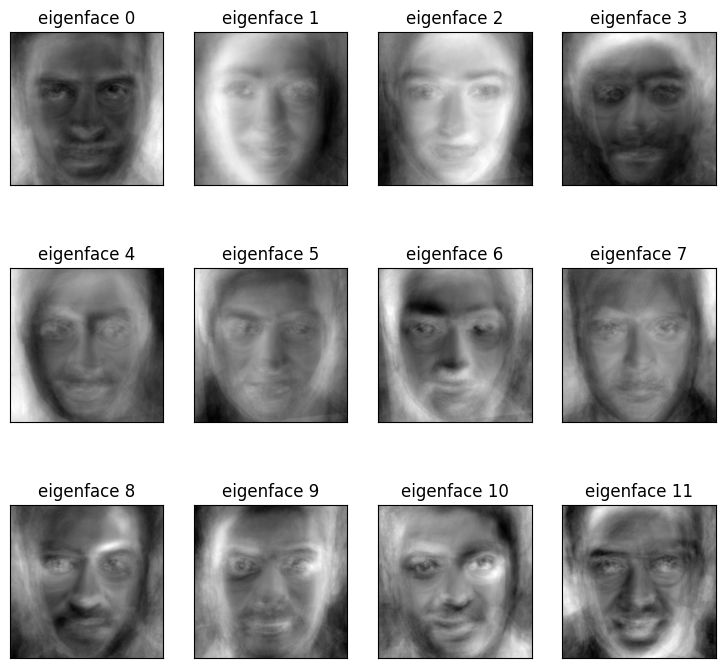

Projecting the input data on the eigenfaces orthonormal basis
(337, 170) (113, 170)


In [72]:
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set

X_train, X_test, y_train, y_test= train_test_split( X, y, test_size=0.25, random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction/dimensionality reduction 
n_components = 170

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))

# Applying PCA
pca=PCA(n_components=n_components,svd_solver='randomized', whiten=True).fit(X_train)

# Generating eigenfaces
eigenfaces= pca.components_.reshape((n_components, h, w))

#plot the gallery of the most significative eigenfaces
eigenface_titles=["eigenface %d" % i for i in range(eigenfaces.shape[0])]

plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

print("Projecting the input data on the eigenfaces orthonormal basis")

X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)
print(X_train_pca.shape,X_test_pca.shape)

# Compute Fisherfaces
lda=LinearDiscriminantAnalysis()

#Compute LDA of reduced data

lda.fit(X_train_pca, y_train)

X_train_lda= lda.transform(X_train_pca)

X_test_lda= lda.transform(X_test_pca)


In [73]:
# Training with Multi Layer perceptron

clf=MLPClassifier(random_state=1, hidden_layer_sizes=(100,50),alpha=0.00005, learning_rate_init=0.0005, max_iter=3000, verbose=True).fit(X_train_lda, y_train)

print("Model Weights:")
model_info=[coef.shape for coef in clf.coefs_]
print(model_info)

Iteration 1, loss = 2.71670655
Iteration 2, loss = 2.53438858
Iteration 3, loss = 2.37437166
Iteration 4, loss = 2.22319790
Iteration 5, loss = 2.08374305
Iteration 6, loss = 1.94841033
Iteration 7, loss = 1.82391432
Iteration 8, loss = 1.70825123
Iteration 9, loss = 1.60071548
Iteration 10, loss = 1.49856797
Iteration 11, loss = 1.40529952
Iteration 12, loss = 1.31826359
Iteration 13, loss = 1.23676831
Iteration 14, loss = 1.16240958
Iteration 15, loss = 1.09323124
Iteration 16, loss = 1.02802003
Iteration 17, loss = 0.96793299
Iteration 18, loss = 0.91158387
Iteration 19, loss = 0.85816594
Iteration 20, loss = 0.80811666
Iteration 21, loss = 0.76028846
Iteration 22, loss = 0.71513433
Iteration 23, loss = 0.67351852
Iteration 24, loss = 0.63371631
Iteration 25, loss = 0.59615099
Iteration 26, loss = 0.56111564
Iteration 27, loss = 0.52743600
Iteration 28, loss = 0.49585909
Iteration 29, loss = 0.46645215
Iteration 30, loss = 0.43850787
Iteration 31, loss = 0.41249964
Iteration 32, los

Accuracy: 79.64601769911505


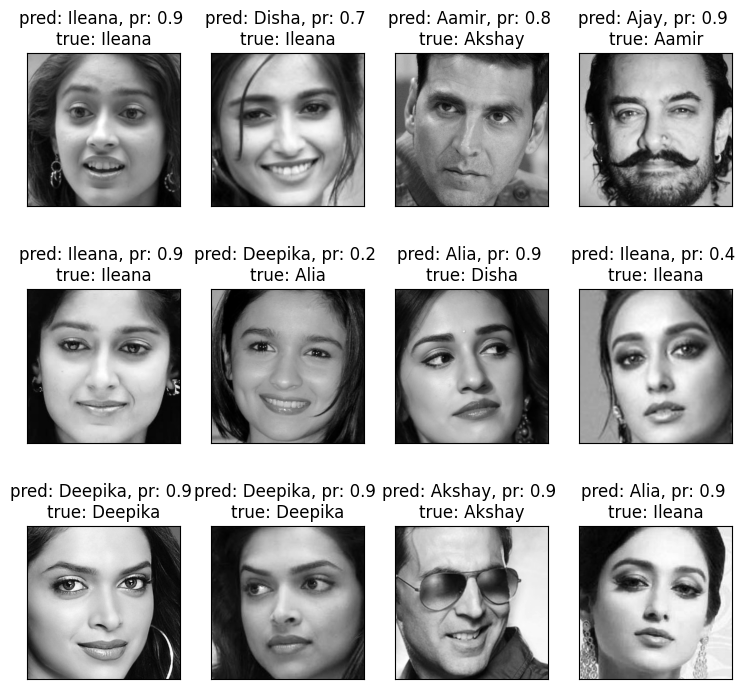

In [74]:
y_pred=[]
y_prob=[]
for test_face in X_test_lda:
    prob =clf.predict_proba([test_face])[0]
    class_id= np.where(prob == np.max(prob))[0][0]
    #Find the Label of the mathed face

    y_pred.append(class_id)
    y_prob.append(np.max(prob))

#Transform the data

y_pred=np.array(y_pred)

prediction_titles=[]

true_positive = 0

for i in range(y_pred.shape[0]):

    true_name= class_names[y_test[i]]

    pred_name = class_names[y_pred[i]]

    result = 'pred: %s, pr: %s \ntrue: %s' % (pred_name, str(y_prob[i]) [0:3], true_name)

    #result 'prediction: %s \ntrue: %s' % (pred name, true name)
    prediction_titles.append(result)

    if true_name==pred_name:
        true_positive =true_positive+1

print("Accuracy:", true_positive*100/y_pred.shape[0])

##Plot results

plot_gallery(X_test, prediction_titles, h, w)

plt.show()

Iteration 1, loss = 2.27392758
Iteration 2, loss = 2.24934515
Iteration 3, loss = 2.22732534
Iteration 4, loss = 2.20619995
Iteration 5, loss = 2.18560023
Iteration 6, loss = 2.16625429
Iteration 7, loss = 2.14785638
Iteration 8, loss = 2.12875563
Iteration 9, loss = 2.11172121
Iteration 10, loss = 2.09459892
Iteration 11, loss = 2.07795687
Iteration 12, loss = 2.06160856
Iteration 13, loss = 2.04585725
Iteration 14, loss = 2.03003344
Iteration 15, loss = 2.01398095
Iteration 16, loss = 1.99888127
Iteration 17, loss = 1.98321914
Iteration 18, loss = 1.96804344
Iteration 19, loss = 1.95262806
Iteration 20, loss = 1.93722911
Iteration 21, loss = 1.92224638
Iteration 22, loss = 1.90703063
Iteration 23, loss = 1.89148870
Iteration 24, loss = 1.87680737
Iteration 25, loss = 1.86128467
Iteration 26, loss = 1.84596665
Iteration 27, loss = 1.83105146
Iteration 28, loss = 1.81508868
Iteration 29, loss = 1.79993302
Iteration 30, loss = 1.78392297
Iteration 31, loss = 1.76828303
Iteration 32, los

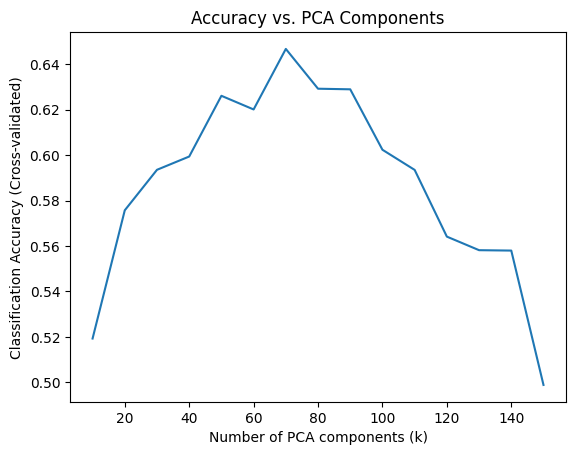

In [75]:
accuracies = []
k_values = range(10, 160, 10)
for k in k_values:
    pca = PCA(n_components=k, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    scores = cross_val_score(clf, X_train_pca, y_train, cv=5)  # 5-fold cross-validation
    accuracies.append(scores.mean())
    
plt.plot(k_values, accuracies)
plt.xlabel("Number of PCA components (k)")
plt.ylabel("Classification Accuracy (Cross-validated)")
plt.title("Accuracy vs. PCA Components")
plt.show()
